In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [244]:
df=pd.read_csv("data.csv")


In [245]:
df.head()

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,2,"Baimbrigge, Mr. Charles Robert",male,23.0,0,0,C.A. 31030,10.5000,NaN,S,Guernsey
1,1,0,3,"Aronsson, Mr. Ernst Axel Algot",male,24.0,0,0,349911,7.7750,NaN,S,"Sweden Joliet, IL"
2,2,0,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C,NaN
3,3,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,NaN
4,4,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S,"Nice, France"


In [246]:
#odstranění přebytečných sloupců, které nám nedávají žádnou dodatečnou informaci¨
df=df.drop(columns=['ID','name'])

In [247]:
object_columns=df.select_dtypes('object').columns
object_columns

Index(['sex', 'ticket', 'cabin', 'embarked', 'home.dest'], dtype='object')

In [248]:
df.head()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,2,male,23.0,0,0,C.A. 31030,10.5000,NaN,S,Guernsey
1,0,3,male,24.0,0,0,349911,7.7750,NaN,S,"Sweden Joliet, IL"
2,0,3,male,28.5,0,0,2697,7.2292,NaN,C,NaN
3,0,3,male,16.0,0,0,7534,9.2167,NaN,S,NaN
4,1,2,male,3.0,1,1,230080,26.0000,F2,S,"Nice, France"


In [249]:

#Vytvoření kategorie sex_category
sex_category=pd.api.types.CategoricalDtype(categories=['Female','Male'])
df['sex']=df['sex'].astype(sex_category).cat.codes
df[object_columns]=df[object_columns].astype('category').apply(lambda x: x.cat.codes)

#Nahrazení chybějících hodnot ve sloupci age mediánem věku pasažerů
df['age']=df['age'].fillna(df['age'].median())

#Zbylé chybějící hodnoty nahrazeny -1
df=df.replace(np.nan,-1)


In [250]:
df

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,2,0,23.0,0,0,606,10.5000,-1,2,113
1,0,3,0,24.0,0,0,431,7.7750,-1,2,266
2,0,3,0,28.5,0,0,232,7.2292,-1,0,-1
3,0,3,0,16.0,0,0,554,9.2167,-1,2,-1
4,1,2,0,3.0,1,1,119,26.0000,149,2,205
...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,0,26.0,1,1,178,26.0000,-1,2,190
996,0,2,0,18.0,1,1,177,13.0000,-1,2,152
997,1,1,0,53.0,2,0,63,51.4792,52,2,14
998,0,2,0,34.0,1,0,118,26.0000,-1,2,288


In [251]:
#Rozdělení dat na vysvětlovanou proměnnou a jednotlivé příznaky
from sklearn.model_selection import train_test_split
y=df['survived']
x=df.drop(columns=['survived'])
random_seed=42

#Rozdělení dat na trénovací, validační a testovací množinu (60% trénovací, 20% validační, 20% testovací)
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.6,random_state=random_seed)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,random_state=random_seed,test_size=0.5)

In [252]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics

#Zvolení parametrů pro rozhodovací strom a jejich rozsah
params={'depth':range(1,31),
        'criterion':['gini','entropy']}
param_grid=ParameterGrid(params)


train_DT=[]
val_DT=[]

#Iterace sloužící k určení pro kterou dvojici parametrů má rozhodovací strom nejvyšší přesnost
for param in param_grid:
  DecisionTree=DecisionTreeClassifier(max_depth=param['depth'],criterion=param['criterion'])
  DecisionTree.fit(xtrain,ytrain)
  train_DT.append(metrics.accuracy_score(ytrain,DecisionTree.predict(xtrain)))
  val_DT.append(metrics.accuracy_score(yval,DecisionTree.predict(xval)))


Text(0, 0.5, 'Accuracy')

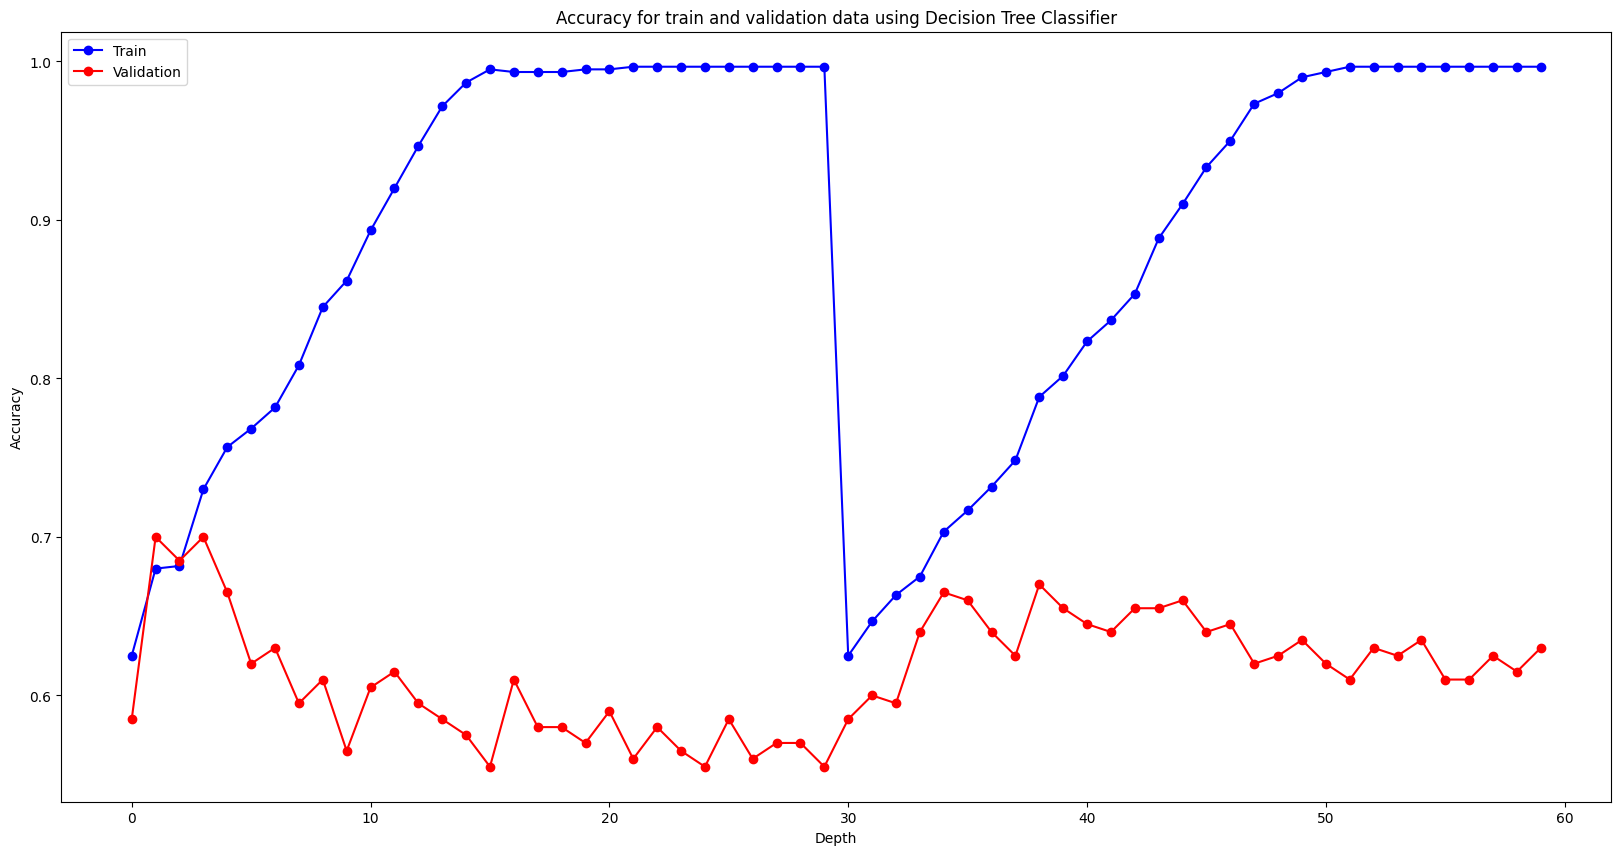

In [253]:
#Vykreslení přesností trénovací a validační množiny v závislosti na zvolených parametrech
plt.figure(figsize=(20,10))
plt.title("Accuracy for train and validation data using Decision Tree Classifier")
plt.plot(train_DT,'ob-')
plt.plot(val_DT,'or-')
plt.legend(['Train','Validation'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')


In [254]:
# U rozhodovacích stromů je nevýhoda, že i malá změna v trénovacích datech může mít velký vliv na celkovou strukturu stromů
# Také je u nich nevýhoda, že jsou snadné na přeučení, což je patrné i z grafu uvedeného výše.
# Velkou výhodou je u nich dobrá interpretovatelnost jednotlivých rozhodnutí

In [255]:
#Volba nejvhodnějšího hyperparametru, který má nejvyšší přesnost na validační množině
best_param=param_grid[np.argmax(val_DT)]
best_param

{'depth': 2, 'criterion': 'gini'}

In [256]:
#Trénik stromu s nejlepšími parametry
DecisionTree_best=DecisionTreeClassifier(max_depth=best_param['depth'],criterion=best_param['criterion'])
DecisionTree_best.fit(xtrain,ytrain)
print(metrics.accuracy_score(ytrain,DecisionTree_best.predict(xtrain)))
print(metrics.accuracy_score(yval,DecisionTree_best.predict(xval)))
print(metrics.accuracy_score(ytest,DecisionTree_best.predict(xtest)))

0.68
0.7
0.735


In [257]:
#Přepdzpracování dat (jejich škálování), aby byla vhodná na využití metody K nejbližších sousedů
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
xtrain_scaled=scaler.fit_transform(xtrain)
xval_scaled=scaler.transform(xval)
xtest_scaled=scaler.transform(xtest)

In [258]:
from sklearn.neighbors import KNeighborsClassifier
train_KNN=[]
val_KNN=[]

# Iterace přes jednotlivé mnou zvolené hloubky v rozsahu 3-30 sloužící k určení, pro kterou hloubku má metoda K nejbližších sousedů nejvyšší přesnost
for i in range(3,31):
  KNeighbor=KNeighborsClassifier(n_neighbors=i)
  KNeighbor.fit(xtrain_scaled,ytrain)
  train_KNN.append(KNeighbor.score(xtrain_scaled,ytrain))
  val_KNN.append(KNeighbor.score(xval_scaled,yval))


(3.0, 28.0)

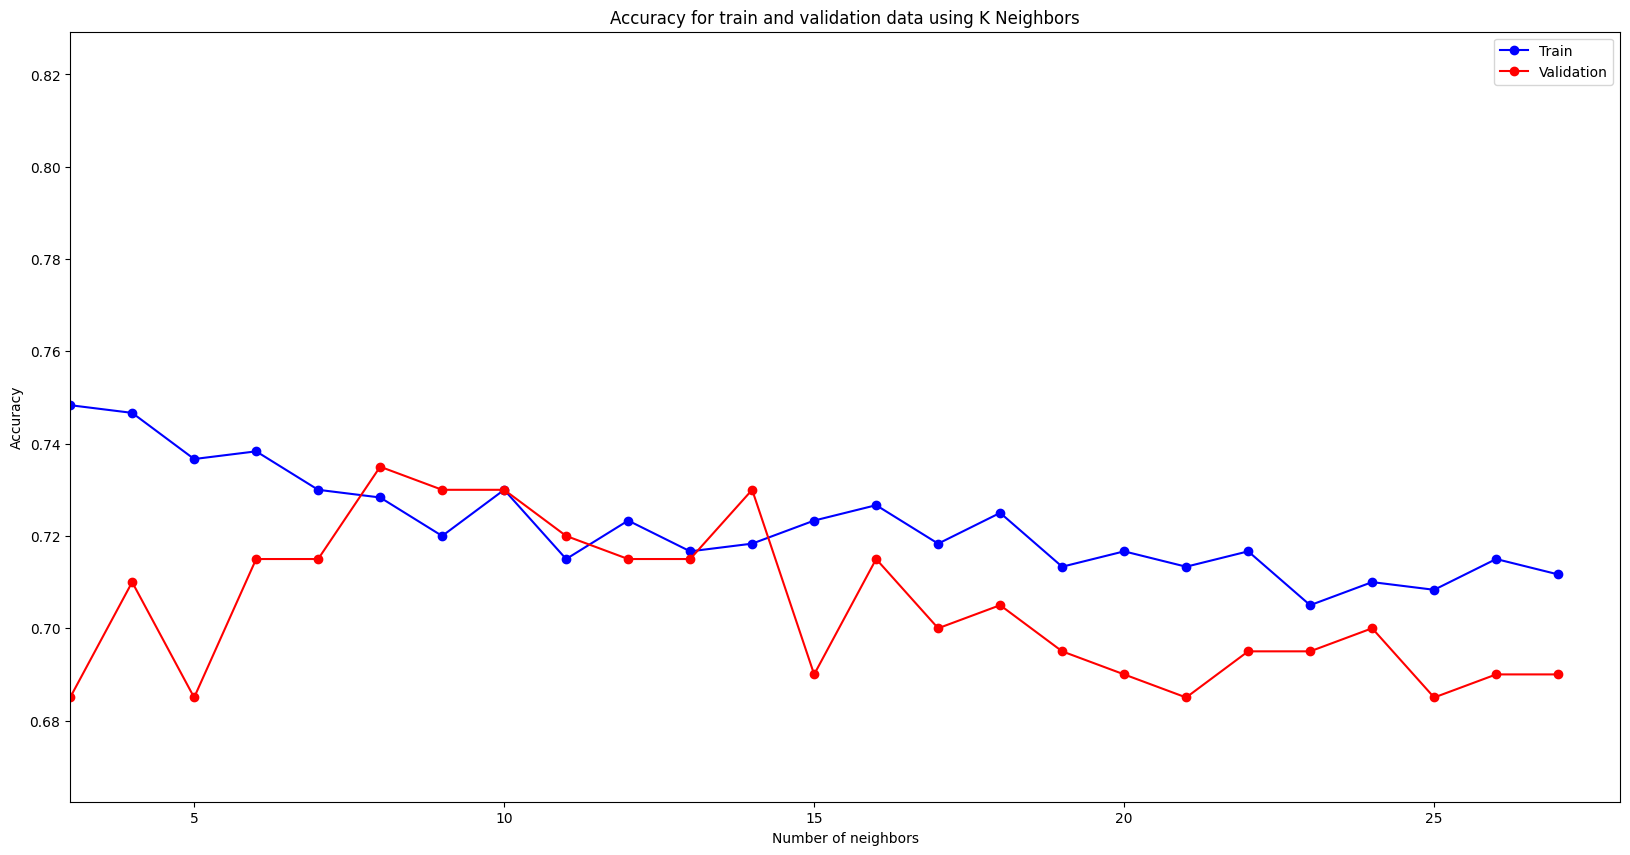

In [259]:
#Vykreslení přesností pro trénovací a validační množinu u KNN
plt.figure(figsize=(20,10))
plt.title("Accuracy for train and validation data using K Neighbors")
plt.plot(train_KNN,"ob-")
plt.plot(val_KNN,"or-")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'])
plt.xlim(3, len(train_KNN))

In [260]:
# U KNN může být u velkého počtu příznakuů velký problém prokletí dimenzionality, data se při zvyšování dimenze od sebe vzdalují a snížují tak zásadně přesnost modelu
# Výhodou KNN je, že trénovací data jsou už sama naučeným modelem

In [261]:
#Volba nejvhodnějšího hyperparametru, který má nejvyšší přesnost na validační množině
best_index=np.argmax(val_KNN)
best_param=best_index+3
print(best_param)
#Trénování KNN s nejvyšší přesností na validační množině
KNeighbor_best=KNeighborsClassifier(n_neighbors=best_param)
KNeighbor_best.fit(xtrain_scaled,ytrain)
print(KNeighbor_best.score(xtrain_scaled,ytrain))
print(KNeighbor_best.score(xval_scaled,yval))
print(KNeighbor_best.score(xtest_scaled,ytest))

11
0.7283333333333334
0.735
0.74


In [262]:
#Matice záměn pro rozhodovací strom a knn
from sklearn.metrics import confusion_matrix
DT_matrix=confusion_matrix(ytest,DecisionTree_best.predict(xtest))
KNN_matrix=confusion_matrix(ytest,KNeighbor_best.predict(xtest_scaled))
print("Rozhodovací strom:")
print(DT_matrix)
print("\n")
print("K nejbližších sousedů:")
print(KNN_matrix)


Rozhodovací strom:
[[127   8]
 [ 45  20]]


K nejbližších sousedů:
[[116  19]
 [ 33  32]]


In [263]:
#Přesnost a F1 skore pro rozhodovací strom a KNN
accuracy_score_DT=metrics.accuracy_score(ytest,DecisionTree_best.predict(xtest))
accuracy_score_KNN=metrics.accuracy_score(ytest,KNeighbor_best.predict(xtest_scaled))
f1Score_DT=metrics.f1_score(ytest,DecisionTree_best.predict(xtest))
f1_score_KNN=metrics.f1_score(ytest,KNeighbor_best.predict(xtest_scaled))
print(accuracy_score_DT)
print(accuracy_score_KNN)
print(f"Přesno pro Rozhodovací strom je: {accuracy_score_DT:.3f}")
print(f"Přesnost skore pro KNN je: {accuracy_score_KNN:.3f}")
print(f"F1 skore pro Rozhodovací strom je: {f1Score_DT:.3f}")
print(f"F1 skore pro KNN je: {f1_score_KNN:.3f}")

0.735
0.74
Přesno pro Rozhodovací strom je: 0.735
Přesnost skore pro KNN je: 0.740
F1 skore pro Rozhodovací strom je: 0.430
F1 skore pro KNN je: 0.552


In [264]:
#Predikce pravděpodobností pro ROC křivku
y_prob_DT=DecisionTree_best.predict_proba(xval)
y_prob_KNN=KNeighbor_best.predict_proba(xval_scaled)

#Výpočet ROC křivky pro rozhodovací strom a KNN
fp_DT,tp_DT,threshold_DT=metrics.roc_curve(yval,y_prob_DT[:,1])
fp_KNN,tp_KNN,threshold_KNN=metrics.roc_curve(yval,y_prob_KNN[:,1])

#Výpočet AUC pro rozhodovací stromy a KNN
AUC_DT=metrics.roc_auc_score(yval,y_prob_DT[:,1])
AUC_KNN=metrics.roc_auc_score(yval,y_prob_KNN[:,1])
AUC_DT

0.6767068273092369

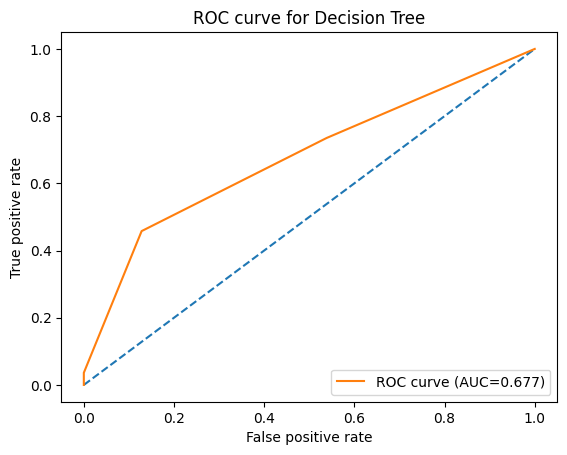

In [265]:
#Vykreslení ROC křivky pro rozhodovací stromy
plt.figure()
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fp_DT,tp_DT,label=f"ROC curve (AUC={AUC_DT:.3f})")
plt.title("ROC curve for Decision Tree")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")

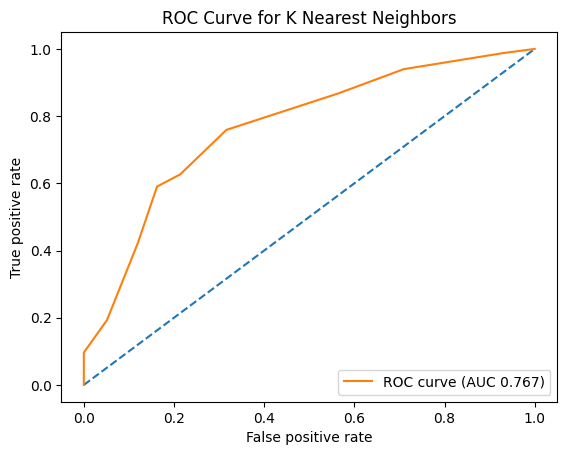

In [266]:
#Vykreslení ROC křivky pro K nejbližších sousedů
plt.figure()
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fp_KNN,tp_KNN,label=f"ROC curve (AUC {AUC_KNN:.3f})")
plt.title("ROC Curve for K Nearest Neighbors")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")

In [267]:
# Na základě provedené analýzy je lepším modelem KNN, je pro to několik důvodů, má vyšší AUC skore, které dosahuje hodnoty 0.767
# KNN má rovněž vyšší hodnoty přesnosti a f1 skore, oproti rozhodovacím stromům.
# Z toho důvodu jednoznačně vybírám jako vhodný model K nejbližších sousedů KNN s hyperparametrem počtu sousedů 11.
# Na nových datech mohu očekávat správnost výsledků okolo 77% (na základě AUC skore)

In [268]:

df_eval=pd.read_csv("evaluation.csv")

In [269]:
#Funkce která transformuje data dle postupu uvedeném na začátku
def data_preprocessing(df):
    df = df.drop(columns=['ID','name'])
    object_columns = df.select_dtypes('object').columns
    sex_category = pd.api.types.CategoricalDtype(categories=['Female', 'Male'])
    df['sex'] = df['sex'].astype(sex_category).cat.codes
    df[object_columns] = df[object_columns].astype('category').apply(lambda x: x.cat.codes)
    df['age'] = df['age'].fillna(df['age'].median())
    df = df.replace(np.nan, -1)
    return df

df_eval=data_preprocessing(df_eval)

In [270]:
#Vytvoření nového sloupce survived na základě nejlepšího vybraného modelu
df_eval['survived']=KNeighbor_best.predict(df_eval)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [271]:
#Vytvoření nového souboru results.csv
df_eval[['survived']].to_csv()
df_eval.reset_index(drop=True, inplace=True)
df_eval.index += 1000
df_eval['ID'] = df_eval.index
df_eval[['ID', 'survived']].to_csv('results.csv', index=False)